 # Dependencies

In [1]:
# Dependencies
!pip install spacy
!pip install pyfiglet

import pyfiglet
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import re
import os
import spacy
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Download the English language model
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.8/865.8 kB 23.8 MB/s eta 0:00:0000:01


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 68.9 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/elon-musk-tweets/elon_musk_tweets.csv
/kaggle/input/elon-musk-tweets/wandb/run-20230521_061602-145od6hx/run-145od6hx.wandb
/kaggle/input/elon-musk-tweets/wandb/run-20230521_061602-145od6hx/logs/debug.log
/kaggle/input/elon-musk-tweets/wandb/run-20230521_061602-145od6hx/logs/debug-internal.log
/kaggle/input/elon-musk-tweets/wandb/run-20230521_061602-145od6hx/files/wandb-summary.json
/kaggle/input/elon-musk-tweets/wandb/run-20230521_061602-145od6hx/files/conda-environment.yaml
/kaggle/input/elon-musk-tweets/wandb/run-20230521_061602-145od6hx/files/config.yaml
/kaggle/input/elon-musk-tweets/wandb/run-20230521_061602-145od6hx/files/output.log
/kaggle/input/elon-musk-tweets/wandb/run-20230521_061602-145od6hx/files/requirements.txt
/kaggle/input/elon-musk-tweets/wandb/run-20230521_061602-145od6hx/files/wandb-metadata.json


# Loading the Dataset

In [3]:
df =  pd.read_csv('/kaggle/input/elon-musk-tweets/elon_musk_tweets.csv')
df.head

<bound method NDFrame.head of                        id  user_name user_location           user_description  \
0     1544379368478212100  Elon Musk           NaN  Mars & Cars, Chips & Dips   
1     1544377493263720450  Elon Musk           NaN  Mars & Cars, Chips & Dips   
2     1544377130590552064  Elon Musk           NaN  Mars & Cars, Chips & Dips   
3     1544375575724400645  Elon Musk           NaN  Mars & Cars, Chips & Dips   
4     1544375148605853699  Elon Musk           NaN  Mars & Cars, Chips & Dips   
...                   ...        ...           ...                        ...   
5402  1656720044666281984  Elon Musk           NaN                        NaN   
5403  1656719617577070593  Elon Musk           NaN                        NaN   
5404  1656700605174513664  Elon Musk           NaN                        NaN   
5405  1656692047791919105  Elon Musk           NaN                        NaN   
5406  1656602293457010688  Elon Musk           NaN                        NaN  

# Dealing with Missing Count

In [4]:
# Check the number of missing values in each column
missing_values = df.isnull().sum()
print("Missing Values:")
print(missing_values)

Missing Values:
id                     0
user_name              0
user_location       4357
user_description    4029
user_created           0
user_followers         0
user_friends           0
user_favourites        0
user_verified          0
date                   0
text                   0
hashtags            5405
source                 0
retweets               0
favorites              0
is_retweet             0
dtype: int64


In [5]:
# Check the number of missing values in each column
missing_values = df.isnull().sum()
print("Missing Values:")
print(missing_values)

# Replace missing values in 'user_location' column with 'Unknown'
df['user_location'] = df['user_location'].fillna('Unknown')

# Replace missing values in 'user_description' column with 'No description'
df['user_description'] = df['user_description'].fillna('No description')

# Replace missing values in 'hashtags' column with 'No hashtags'
df['hashtags'] = df['hashtags'].fillna('No hashtags')


Missing Values:
id                     0
user_name              0
user_location       4357
user_description    4029
user_created           0
user_followers         0
user_friends           0
user_favourites        0
user_verified          0
date                   0
text                   0
hashtags            5405
source                 0
retweets               0
favorites              0
is_retweet             0
dtype: int64


In [6]:
df.isna().sum()

id                  0
user_name           0
user_location       0
user_description    0
user_created        0
user_followers      0
user_friends        0
user_favourites     0
user_verified       0
date                0
text                0
hashtags            0
source              0
retweets            0
favorites           0
is_retweet          0
dtype: int64

# Text Processing

In [7]:
nlp = spacy.load('en_core_web_sm')

def preprocess_text(text):
    # Remove special characters and digits
    text = re.sub(r'\W+|\d+', ' ', text)
    
    # Tokenization, lemmatization, and stop word removal using spaCy
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop]
    
    # Join tokens back to text
    processed_text = ' '.join(tokens)
    
    return processed_text

In [8]:
df['text_processed'] = df['text'].apply(preprocess_text)

# Sentiment Analysis

In [9]:
# Sentiment Analysis
sia = SentimentIntensityAnalyzer()
df['sentiment'] = df['text'].apply(lambda x: sia.polarity_scores(x)['compound'])
df['sentiment_category'] = df['sentiment'].apply(lambda x: 'Positive' if x > 0 else 'Negative' if x < 0 else 'Neutral')

In [10]:
df['sentiment_category']

0       Negative
1        Neutral
2        Neutral
3        Neutral
4       Positive
          ...   
5402    Positive
5403    Positive
5404     Neutral
5405    Positive
5406     Neutral
Name: sentiment_category, Length: 5407, dtype: object

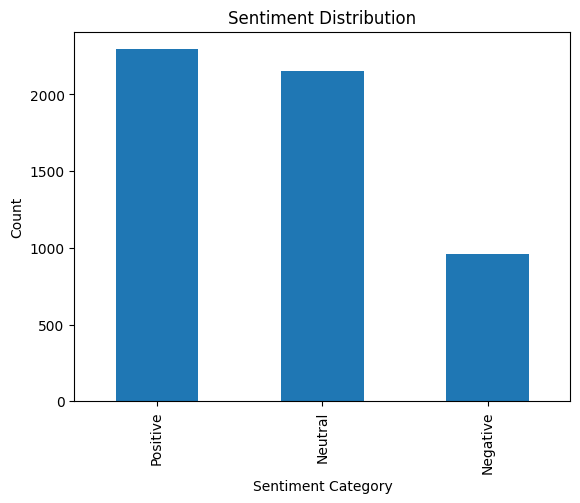

In [11]:
# Sentiment Distribution:
sentiment_counts = df['sentiment_category'].value_counts()
sentiment_counts.plot(kind='bar')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()

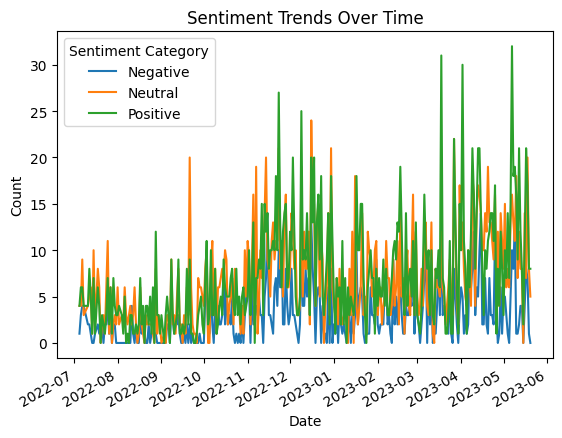

In [12]:
# Sentiment Trends Over Time:
df['date'] = pd.to_datetime(df['date'])
sentiment_by_date = df.groupby(pd.Grouper(key='date', freq='D'))['sentiment_category'].value_counts().unstack().fillna(0)
sentiment_by_date.plot()
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Sentiment Trends Over Time')
plt.legend(title='Sentiment Category')
plt.show()


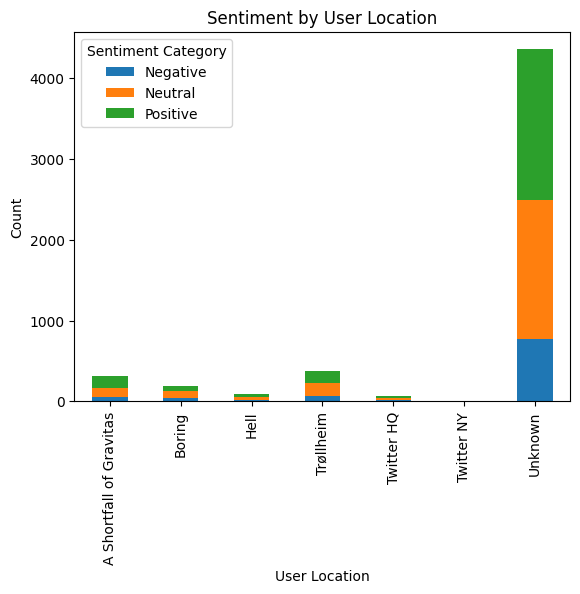

In [13]:
# Sentiment by User Location:
sentiment_by_location = df.groupby('user_location')['sentiment_category'].value_counts().unstack().fillna(0)
sentiment_by_location.plot(kind='bar', stacked=True)
plt.xlabel('User Location')
plt.ylabel('Count')
plt.title('Sentiment by User Location')
plt.legend(title='Sentiment Category')
plt.show()

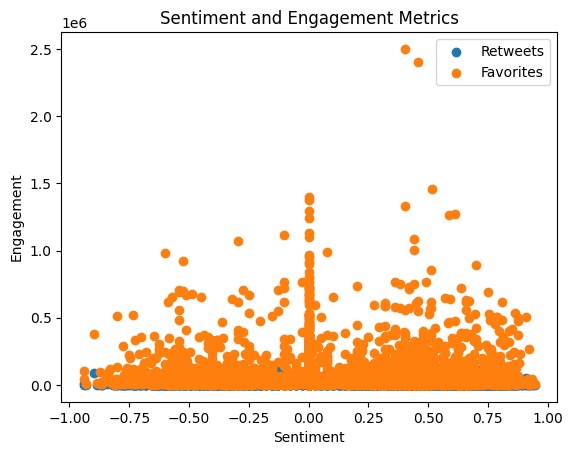

In [14]:
# Sentiment and Engagement Metrics:
df['retweets'] = df['retweets'].astype(int)
df['favorites'] = df['favorites'].astype(int)

plt.scatter(df['sentiment'], df['retweets'], label='Retweets')
plt.scatter(df['sentiment'], df['favorites'], label='Favorites')
plt.xlabel('Sentiment')
plt.ylabel('Engagement')
plt.title('Sentiment and Engagement Metrics')
plt.legend()
plt.show()

# Word Cloud of Sentiments

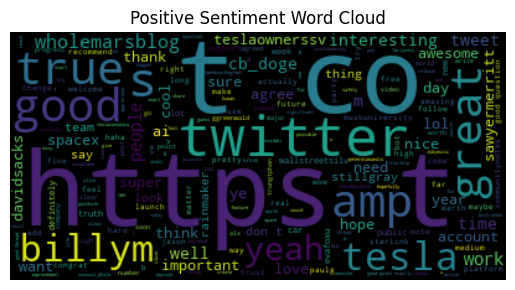

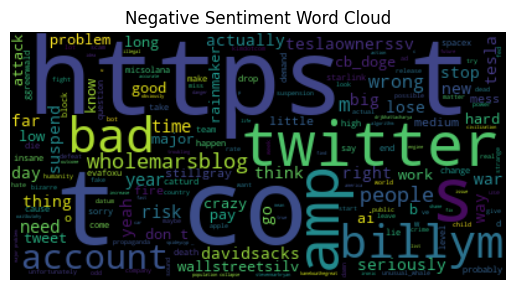

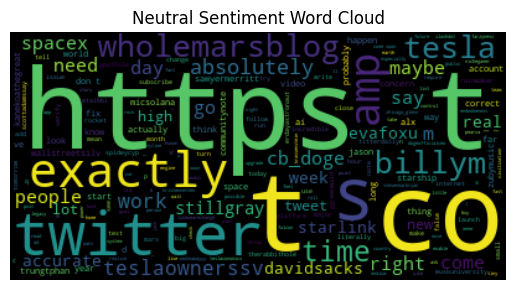

In [15]:
positive_tweets = df[df['sentiment_category'] == 'Positive']['text_processed'].str.cat(sep=' ')
negative_tweets = df[df['sentiment_category'] == 'Negative']['text_processed'].str.cat(sep=' ')
neutral_tweets = df[df['sentiment_category'] == 'Neutral']['text_processed'].str.cat(sep=' ')

wordcloud_positive = WordCloud().generate(positive_tweets)
wordcloud_negative = WordCloud().generate(negative_tweets)
wordcloud_neutral = WordCloud().generate(neutral_tweets)

plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Sentiment Word Cloud')
plt.axis('off')
plt.show()

plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Sentiment Word Cloud')
plt.axis('off')
plt.show()

plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.title('Neutral Sentiment Word Cloud')
plt.axis('off')
plt.show()

# Topic Modelling

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Create an instance of CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the preprocessed text data
X = vectorizer.fit_transform(df['text_processed'])

# Get the feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Create an instance of LatentDirichletAllocation and fit it to the vectorized data
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

# Print the most important words for each topic
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic #{topic_idx}:")
    top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]
    print(" ".join(top_words))
    print()


Topic #0:
co https twitter amp billym true yeah time exactly like

Topic #1:
co https tesla twitter amp wallstreetsilv exactly come sawyermerritt account

Topic #2:
https co spacex amp launch year like good day need

Topic #3:
good wholemarsblog interesting absolutely look co https like day maybe

Topic #4:
co https twitter billym great amp people agree right video



# Retweet Analysis

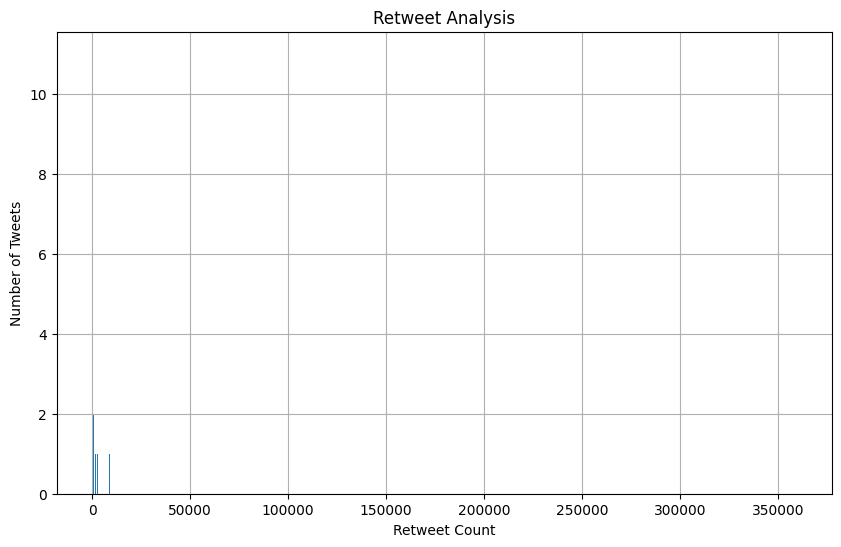

In [17]:
# Group the data by retweet count and calculate the total number of retweets for each count
retweet_counts = df.groupby('retweets').size().reset_index(name='count')

# Sort the retweet counts in descending order
retweet_counts = retweet_counts.sort_values(by='retweets', ascending=False)

# Plot the retweet analysis
plt.figure(figsize=(10, 6))
plt.bar(retweet_counts['retweets'], retweet_counts['count'])
plt.xlabel('Retweet Count')
plt.ylabel('Number of Tweets')
plt.title('Retweet Analysis')
plt.grid(True)
plt.show()

In [18]:
average_retweets = df['retweets'].mean()
print("Average Retweets:", average_retweets)

Average Retweets: 5699.120399482153


In [19]:
top_retweeted_tweets = df.sort_values(by='retweets', ascending=False).head(5)
print("Top Retweeted Tweets:")
print(top_retweeted_tweets[['text', 'retweets']])

Top Retweeted Tweets:
                                                   text  retweets
999                                   the bird is freed    359672
1012                     Comedy is now legal on Twitter    262233
2218  Should I step down as head of Twitter? I will ...    261976
1452                   Reinstate former President Trump    232743
2020                    My pronouns are Prosecute/Fauci    191910


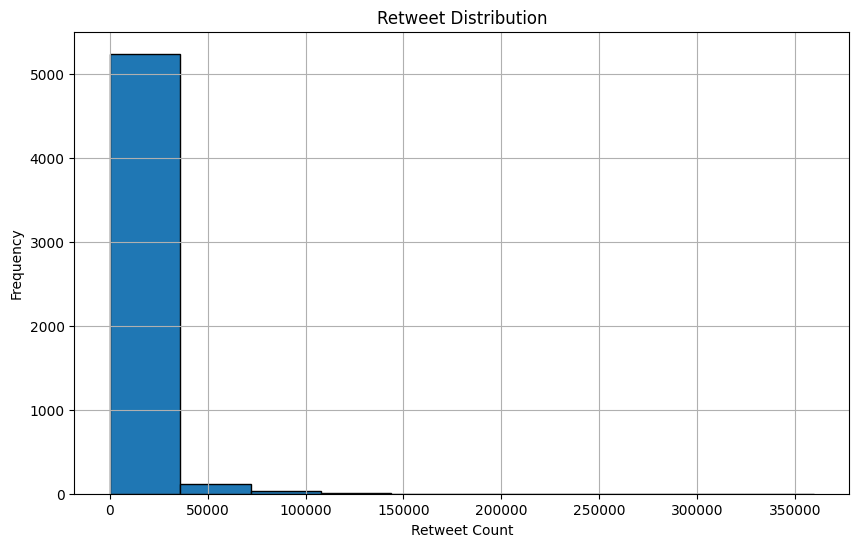

In [20]:
plt.figure(figsize=(10, 6))
plt.hist(df['retweets'], bins=10, edgecolor='k')
plt.xlabel('Retweet Count')
plt.ylabel('Frequency')
plt.title('Retweet Distribution')
plt.grid(True)
plt.show()


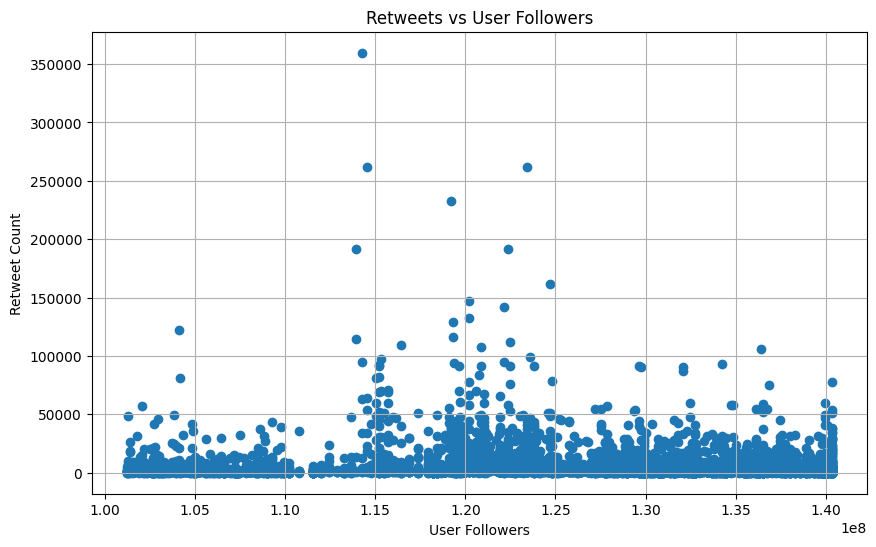

In [21]:
plt.figure(figsize=(10, 6))
plt.scatter(df['user_followers'], df['retweets'])
plt.xlabel('User Followers')
plt.ylabel('Retweet Count')
plt.title('Retweets vs User Followers')
plt.grid(True)
plt.show()


In [22]:
most_retweeted_user = df.loc[df['retweets'].idxmax(), 'user_name']
print("Most Retweeted User:", most_retweeted_user)

Most Retweeted User: Elon Musk


In [23]:
# Generate the ASCII art text
ascii_art = pyfiglet.figlet_format("Thank you")

# Print the ASCII art
print(ascii_art)

NameError: name 'pyfiglet' is not defined